In [2]:
import pandas
import uproot
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interpolate
import pickle

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [3]:
#Dowloading the data
bc_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root')['events']
bu_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU.root')['events']
bb_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen.root')['events']
cc_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zcc_ecm91.root')['events']
qq_tree = uproot.open('/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zuds_ecm91.root')['events']
tree_gen = uproot.open("/eos/experiment/fcc/ee/analyses/case-studies/flavour/Bc2TauNu/flatNtuples/spring2021/prod_04/Analysis_stage2/p8_ee_Zbb_ecm91_EvtGen_Bc2TauNuTAUHADNU.root")["metadata"]

In [4]:
#Transforming the data into a dataframe
bc_df = bc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bu_df = bu_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
bb_df = bb_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
cc_df = cc_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])
qq_df = qq_tree.arrays(library="pd", how="zip", filter_name=["EVT_*"])

#Getting general information on the data
df_gen = tree_gen.arrays(library="pd", how="zip")

In [5]:
#We consider as initial data the data whose MVAs are between 0.95 and 1

bc_sig = bc_df[bc_df['EVT_MVA2']> 0.95]
bc_sig = bc_sig[bc_sig['EVT_MVA1']> 0.95]

bu_bkg = bu_df[bu_df['EVT_MVA2']> 0.95]
bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']> 0.95] 

bb_bkg = bb_df[bb_df['EVT_MVA2']> 0.95]
bb_bkg = bb_bkg[bb_bkg['EVT_MVA1']> 0.95] 

cc_bkg = cc_df[cc_df['EVT_MVA2']> 0.95]
cc_bkg = cc_bkg[cc_bkg['EVT_MVA1']> 0.95] 

qq_bkg = qq_df[qq_df['EVT_MVA2']> 0.95]
qq_bkg = qq_bkg[qq_bkg['EVT_MVA1']> 0.95]

In [6]:
#Number of Z0 produced
N_Z0_init = 5*10**(12)
N_Z0 = 5*10**(12)

#Branching fraction Z->quark-pair
BF_Zbb = 0.1512
BF_Zcc = 0.1203
BF_Zqq = 0.4276

#Production ratio of Bc+ and B+
f_Bc = 0.0004
f_Bu = 0.43

#Branching fraction Bc+->tau nu B+->tau nu and tau->3pions
BF_Bctaunu = 0.0194
BF_Butaunu = 1.09*10**(-4)
BF_tau3pion = 0.0931

In [7]:
#Definition of the functions computing the different yields
def S_bc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bc*BF_Bctaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bu_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2*f_Bu*BF_Butaunu*BF_tau3pion)*initial_eff*cut_eff

def B_bb_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zbb*2)*initial_eff*cut_eff

def B_cc_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zcc*2)*initial_eff*cut_eff

def B_qq_cut(initial_eff, cut_eff) :
    return (N_Z0*BF_Zqq*2)*initial_eff*cut_eff

#Dowloading the splines to compute the number of inclusive background events

bb_spline_MVA1_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA1_spline_log.pkl','rb'))
bb_spline_MVA2_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/MVA2_spline_log.pkl','rb'))

cc_spline_MVA1_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA1_spline_log.pkl','rb'))
cc_spline_MVA2_log = pickle.load(open(r'../Finding_the_best_MVA_cut/2D_plot/Spline_functions/cc_MVA2_spline_log.pkl','rb'))

#qq_spline_MVA1_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA1_spline_log.pkl','rb'))
#qq_spline_MVA2_log = pickle.load(open(r'/Users/mariehartmann/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions/uds_MVA2_spline_log.pkl','rb'))

#http://localhost:8912/tree/Stage_M1/Stage_M1/Bc_to_tau_nu/Finding_the_best_MVA_cut/2D_plot/Spline_functions

In [8]:
#Initialization of the number of events in the MVAs for all contributions
nb_total_events = df_gen.iloc[0]["eventsProcessed"]
nb_bc_events = len(bc_sig)
nb_bu_events = len(bu_bkg)
nb_bb_events = len(bb_bkg)
nb_cc_events = len(cc_bkg)
#nb_qq_events = len(qq_bkg)

#Initialization of the number of events for both MVAs for inclusive backgrounds
nb_bb_events_1 = interpolate.splint(-np.log(1-0.95), 9, bb_spline_MVA1_log)
nb_cc_events_1 = interpolate.splint(-np.log(1-0.95), 9, cc_spline_MVA1_log)
#nb_qq_events_1 = interpolate.splint(-np.log(1-0.95), 8, qq_spline_MVA1_log)

nb_bb_events_2 = interpolate.splint(-np.log(1-0.95), 8, bb_spline_MVA2_log)
nb_cc_events_2 = interpolate.splint(-np.log(1-0.95), 7, cc_spline_MVA2_log)
#nb_qq_events_2 = interpolate.splint(-np.log(1-0.95), 5.8, qq_spline_MVA2_log)

#Computing of the initial efficiencies for all backgrounds
initial_eff_bc_sig = nb_bc_events / nb_total_events
initial_eff_bu_bkg = nb_bu_events / nb_total_events
initial_eff_bb_bkg = nb_bb_events / nb_total_events
initial_eff_cc_bkg = nb_cc_events / nb_total_events
#initial_eff_qq_bkg = nb_qq_events / nb_total_events

In [9]:
#Optimized MVAs
Optimized_MVA1 = 0.9998599999999961  #+-0.00001
Optimized_MVA2 = 0.9963399999999984 #+-0.00001

Optimized_MVA1_log = -np.log(1-Optimized_MVA1)
Optimized_MVA2_log = -np.log(1-Optimized_MVA2)

#Applying the MVA2 cut on the dataframe
df_bc_sig = bc_sig[bc_sig['EVT_MVA1']>Optimized_MVA1]
df_bc_sig = df_bc_sig[df_bc_sig['EVT_MVA2']>Optimized_MVA2]

df_bu_bkg = bu_bkg[bu_bkg['EVT_MVA1']>Optimized_MVA1]
df_bu_bkg = df_bu_bkg[df_bu_bkg['EVT_MVA2']>Optimized_MVA2]
          
#Counting the number of events in the Bc+ and B+ dataframes after the cut
nb_bc_after_cut = len(df_bc_sig)
nb_bu_after_cut = len(df_bu_bkg)
          
#Counting the number of events left for each MVAs for inclusive backgrounds
nb_bb_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, bb_spline_MVA1_log)
nb_bb_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 8, bb_spline_MVA2_log)
        
nb_cc_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 9, cc_spline_MVA1_log)
nb_cc_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 7, cc_spline_MVA2_log)
        
#nb_qq_after_cut_1 = interpolate.splint(Optimized_MVA1_log, 8, qq_spline_MVA1_log)
#nb_qq_after_cut_2 = interpolate.splint(Optimized_MVA2_log, 5.8, qq_spline_MVA2_log)

        
#Computing the efficiencies
cut_eff_bc_sig = nb_bc_after_cut / nb_bc_events
        
cut_eff_bu_bkg = nb_bu_after_cut / nb_bu_events
cut_eff_bb_bkg = (nb_bb_after_cut_1 / nb_bb_events_1) * (nb_bb_after_cut_2 / nb_bb_events_2)
cut_eff_cc_bkg = (nb_cc_after_cut_1 / nb_cc_events_1) * (nb_cc_after_cut_2 / nb_cc_events_2)
#cut_eff_qq_bkg = (nb_qq_after_cut_1 / nb_qq_events_1) * (nb_qq_after_cut_2 / nb_qq_events_2)
print(cut_eff_bu_bkg)
print(cut_eff_bb_bkg)
print(cut_eff_cc_bkg)
#print(cut_eff_qq_bkg)
        
    
#Signal, Background and Purity
S = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)
B = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg) + B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg) + B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg) #+ B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)
P = S/(S+B)

print('Number of signal events = {}'.format(S))
print('Number of bkg events = {}'.format(B))
print('Purity = {}'.format(P))

N_BC = S_bc_cut(initial_eff_bc_sig, cut_eff_bc_sig)

N_BU = B_bu_cut(initial_eff_bu_bkg, cut_eff_bu_bkg)
N_BB = B_bb_cut(initial_eff_bb_bkg, cut_eff_bb_bkg)
N_CC = B_cc_cut(initial_eff_cc_bkg, cut_eff_cc_bkg)
#N_QQ = B_qq_cut(initial_eff_qq_bkg, cut_eff_qq_bkg)

print('N_BC = {}'.format(N_BC))
print('N_BU = {}'.format(N_BU))
print('N_BB = {}'.format(N_BB))
print('N_CC = {}'.format(N_CC))
print('N_BB_CC = {}'.format(N_BB + N_CC))
#print('N_QQ = {}'.format(N_QQ))

0.0007226931575174898
3.137790945458242e-06
1.797967906975173e-06
Number of signal events = 4009.2649482816005
Number of bkg events = 4472.890969373205
Purity = 0.4726705082061383
N_BC = 4009.2649482816005
N_BU = 241.47796710240002
N_BB = 3615.187011064041
N_CC = 616.2259912067639
N_BB_CC = 4231.413002270805


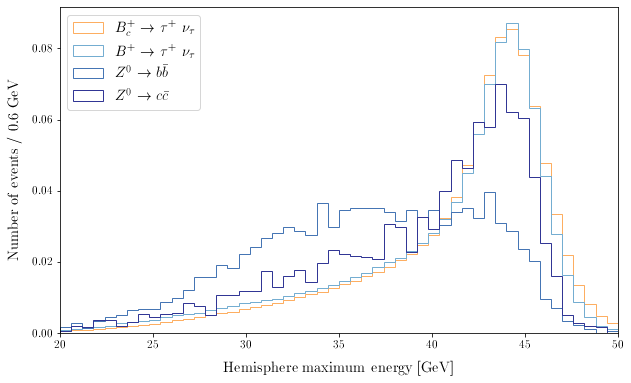

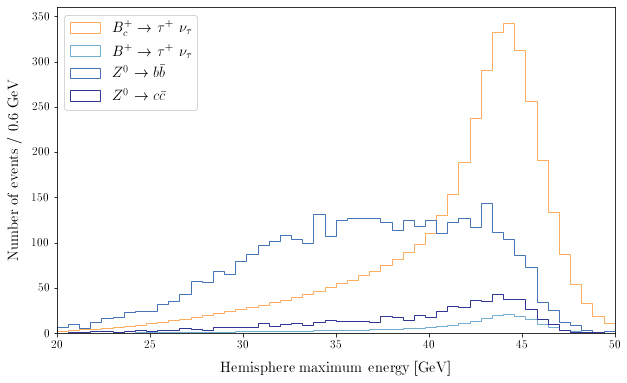

[]

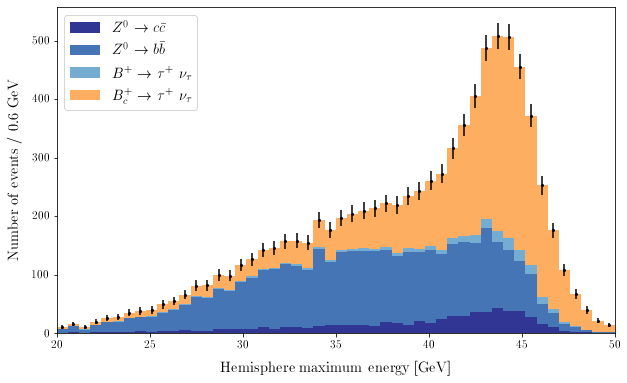

In [11]:
variable = 'EVT_ThrustEmax_E'

nb_bins = int(50/np.sqrt(N_Z0_init/N_Z0))
min_bin = 20
max_bin = 50

name_bc = r"$B_c^+$ $\rightarrow$ $\tau^+$ $\nu_\tau$ "
name_bu = r"$B^+$ $\rightarrow$ $\tau^+$ $\nu_\tau$ "
name_bb = r"$Z^0$ $\rightarrow$ $b\bar{b}$ "
name_cc = r"$Z^0$ $\rightarrow$ $c\bar{c}$ "

colour_bc = "#fdae61"#"#fdae61" #"#fee090" #"#756bb1"
colour_bu = "#74add1"#"#abd9e9" #"#3182bd" #"#2c7fb8" #
colour_bb = "#4575b4"#"#74add1" #43a2ca" #"#edf8b1" #"#a6bddb"
colour_cc = "#313695"#"#4575b4" #"#9ecae1" #"#7fcdbb" #

counts_bc, bins_bc = np.histogram(bc_sig[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bu, bins_bu = np.histogram(bu_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_bb, bins_bb = np.histogram(bb_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))
counts_cc, bins_cc = np.histogram(cc_bkg[variable], bins = nb_bins, range = (min_bin, max_bin))


#With the predicted yields
counts_bc = (counts_bc/np.sum(counts_bc)) * N_BC
counts_bu = (counts_bu/np.sum(counts_bu)) * N_BU
counts_bb = (counts_bb/np.sum(counts_bb)) * N_BB
counts_cc = (counts_cc/np.sum(counts_cc)) * N_CC

plt.figure(figsize=(10,6))
plt.hist(bins_bc[:-1], bins_bc, weights=counts_bc, histtype='step', color= colour_bc, label=name_bc)
plt.hist(bins_bu[:-1], bins_bu, weights=counts_bu, histtype='step', color= colour_bu, label=name_bu)
plt.hist(bins_bb[:-1], bins_bb, weights=counts_bb, histtype='step', color= colour_bb, label=name_bb)
plt.hist(bins_cc[:-1], bins_bb, weights=counts_cc, histtype='step', color= colour_cc, label=name_cc)

plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]", fontsize=15, labelpad=10)
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)), fontsize=15, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=15, loc='upper left')
plt.show()


#Superposed with the predicted yields
x = [bins_bb[:-1], bins_cc[:-1], bins_bu[:-1], bins_bc[:-1]]
bins = bins_bc
weights = [counts_cc, counts_bb, counts_bu, counts_bc ]
colour = [colour_cc, colour_bb, colour_bu, colour_bc]
name = [name_cc, name_bb, name_bu, name_bc]

plt.figure(figsize=(10,6))
counts, bin_edges, _ = plt.hist(x, bins, weights=weights, color=colour, label=name, stacked=True)
bin_centres = (bin_edges[:-1]+ bin_edges[1:])/2
err = np.sqrt(counts[3])
plt.errorbar(bin_centres, counts[3], yerr=err, fmt='o', color='k', markersize=2)

plt.xlim(min_bin,max_bin)
plt.xlabel("Hemisphere maximum energy [GeV]", fontsize=15, labelpad=10)
plt.ylabel("Number of events / {} GeV".format(round((max_bin-min_bin)/nb_bins,3)), fontsize=15, labelpad=10)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=15)
plt.plot()